## 1: Modeling simple dilutions of solutions
### Creating simple dilution models using bellini

Bellini can be used in two modes: functional and procedural. We display examples of these two modes below, using serial dilutions as an example.

### A) Functional mode

We're first going to code the experiment in a functional style: we have device objects that can act on experimental objects, and every manipulation returns new objects post-action.

In [1]:
import bellini
from bellini.quantity import Quantity as Q
from bellini.distributions import Normal, Uniform
from bellini.units import ureg
import networkx as nx

Let's make 1L of 1M solution of glucose in water

In [2]:
from bellini.groups import Species, Solution
from bellini.containers import Container 

water = Species('water')
glucose = Species('glucose')

sugar_water = Solution(
    mixture = glucose * Q(1.0, ureg.mole),
    solvent = water * Q(1.0, ureg.liter)
)

sugar_water_bottle = Container(
    solution = sugar_water
)

sugar_water_bottle

Well containing 1.0 mole / liter of glucose in 1.0 liter of water

We can perform serial dilutions with this solution. Let's make a small well plate, a bulk water solution, and a pipette (which has some error in volume transfer).

In [3]:
from bellini.devices import LiquidTransfer

bulk_water = Container(
    solution = water * Q(1.0, ureg.liter)
)
well_plate = [Container() for i in range(3)]

pipette = LiquidTransfer("pipette", var=Q(0.1, ureg.milliliter))

Wells store solutions, and have a few helper functions to make life a bit easier. Here, we use `pipette`'s `apply` function to transfer liquid from one container to another. This returns two new containers: the container with the solution removed (first) and the container with the solution added (second)

In [4]:
# first dilution
sugar_water_bottle, well_plate[0] = pipette.apply(sugar_water_bottle, well_plate[0], Q(5.0, ureg.milliliter))
bulk_water, well_plate[0] = pipette.apply(bulk_water, well_plate[0], Q(5.0, ureg.milliliter))
# second dilution
well_plate[0], well_plate[1] = pipette.apply(well_plate[0], well_plate[1], Q(5.0, ureg.milliliter))
bulk_water, well_plate[1] = pipette.apply(bulk_water, well_plate[1], Q(5.0, ureg.milliliter))
# third dilution
well_plate[1], well_plate[2] = pipette.apply(well_plate[1], well_plate[2], Q(5.0, ureg.milliliter))
bulk_water, well_plate[2] = pipette.apply(bulk_water, well_plate[2], Q(5.0, ureg.milliliter))

Now, we can observe the concentration with our magic measurement tool (which measures with some error)

In [5]:
from bellini.devices import Measurer
conc_measure = Measurer("magic_measurer", var=Q(0.05, ureg.mole / ureg.liter))
concentration = conc_measure.readout(well_plate[2], value="concentration")
concentration

N(CompDist w mag array(0.125) mol/l, 0.0025000000000000005 mol ** 2 / l ** 2)[mole / liter]

We keep track of an nx graph during all these operations, so we can draw a fancy computation graph. The bottom-most node in the graph is the observed node, and its parents (and grandparents, etc) are listed towards the top.


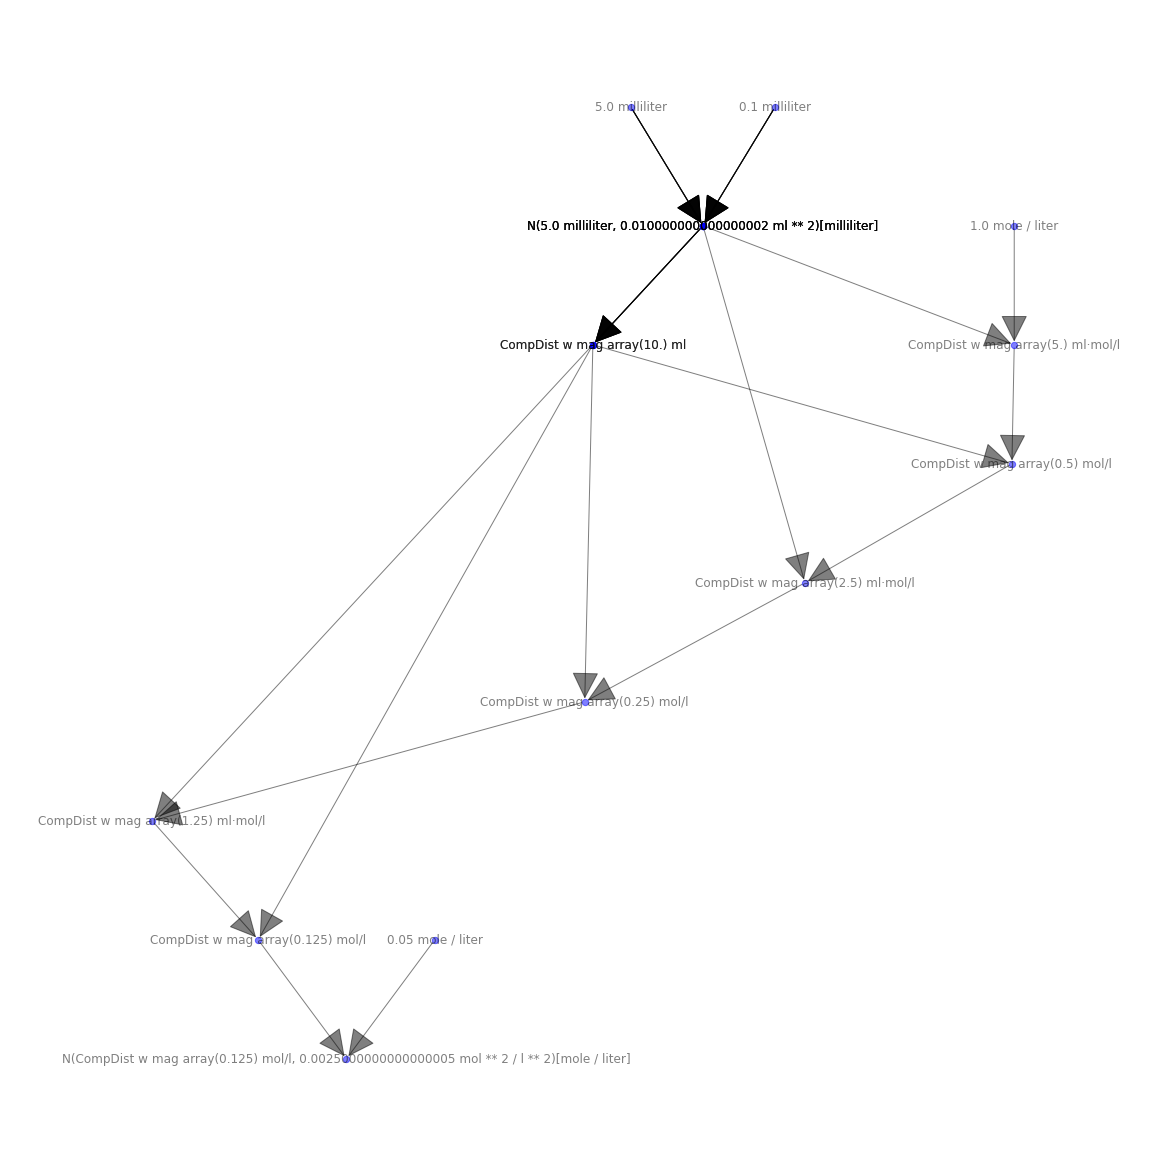

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# This example needs Graphviz and either PyGraphviz or pydot
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

G = concentration.g

labels = {}    
observed_node = concentration

pos = graphviz_layout(G, prog='dot', args='-Granksep=6 -Gnodesep=6') #nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)
#nx.draw_networkx_labels(G,pos,labels, font_color='r', font_size='30')
plt.axis("equal")
plt.show()

This graph can now be converted into a NumPyro model, from which we can simulate the experiment.

In [7]:
# a helpful class wrapper for inference

import numpy as np
import numpyro
import numpyro.distributions as dist
import arviz as az
az.rcParams['plot.max_subplots'] = 48
import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

niter = 500000  # number of iterations
nburn = 50000  # number of burn-in iterations to discard
nthin = 500  # thinning interval

class MCMCModel:
    def __init__(
        self,
        model,
        kernel_args={'step_size':1},
        mcmc_args={"num_warmup": nburn, "num_samples": niter, "thinning": nthin},
    ):
        self.model = model
        self.mcmc = None
        self.kernel_args = kernel_args
        self.mcmc_args = mcmc_args
        self.params = None
        rng_key = random.PRNGKey(0)  # TODO: make option to choose random seed
        self.rng_key_infer, self.rng_key_predict = random.split(rng_key)

    def run_mcmc(self, *args, **kwargs):
        nuts_kernel = NUTS(self.model, **self.kernel_args)
        self.mcmc = MCMC(nuts_kernel, **self.mcmc_args)
        self.mcmc.run(self.rng_key_infer, *args, **kwargs)
        self.sample_params()

    def sample_params(self):
        self.params = self.mcmc.get_samples()

    def predict(self, *args, **kwargs):
        predictor = Predictive(self.model, self.params)
        return predictor(self.rng_key_predict, *args, **kwargs)

    def plot_results(self, exclude_deterministic=False):
        self.mcmc.print_summary(exclude_deterministic=exclude_deterministic)
        data = az.from_numpyro(self.mcmc)
        az.plot_trace(data)

In [8]:
from bellini.api._numpyro import graphs_to_numpyro_model
model = graphs_to_numpyro_model([concentration.g])

mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 10000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc()

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.114.gea315d0.dirty-py3.9.egg/bellini/api/_numpyro.py:52: UserWarning: observed node magic_measurer_Well containing CompDist w mag array(0.125) mol/l of glucose in CompDist w mag array(10.) ml of water_concentration_0 was not given data to condition on. no conditioning performed.
sample: 100%|██████████| 30000/30000 [00:27<00:00, 1082.42it/s, 3 steps of size 8.58e-01. acc. prob=0.85] 



                                                                                                                                            mean       std    median      5.0%     95.0%     n_eff     r_hat
  magic_measurer_Well containing CompDist w mag array(0.125) mol/l of glucose in CompDist w mag array(10.) ml of water_concentration_0      0.12      0.05      0.13      0.04      0.21  25667.26      1.00
                                                                 pipette_N(5.0 milliliter, 0.010000000000000002 ml ** 2)[milliliter]_0      5.00      0.10      5.00      4.83      5.16  25516.18      1.00
                                                                 pipette_N(5.0 milliliter, 0.010000000000000002 ml ** 2)[milliliter]_1      5.00      0.10      5.00      4.84      5.17  27285.12      1.00
                                                                 pipette_N(5.0 milliliter, 0.010000000000000002 ml ** 2)[milliliter]_2      5.00      0.10      5.00      4.83     

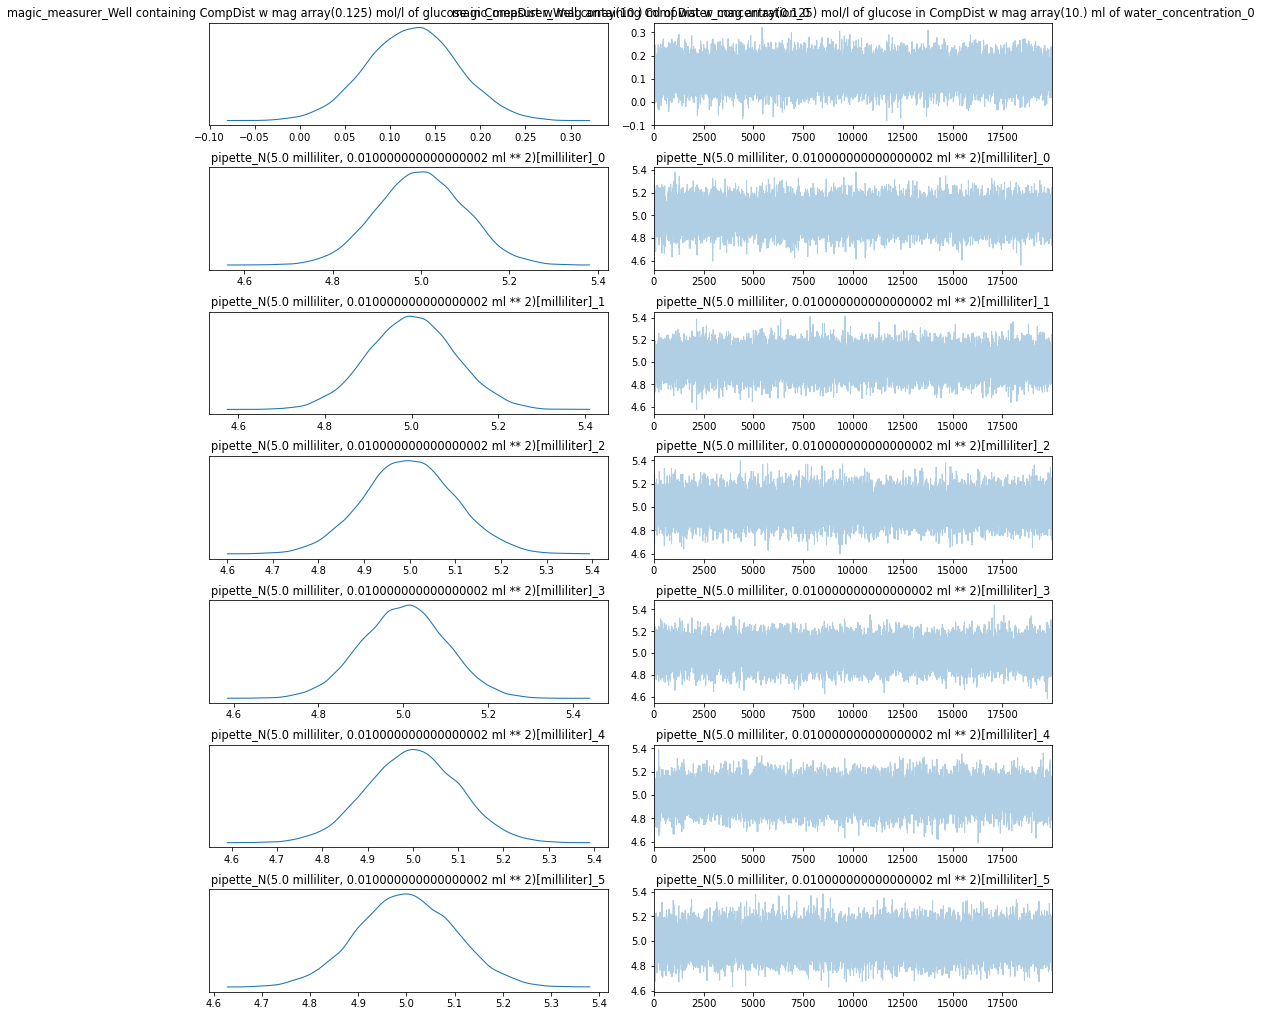

In [9]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

The results are unsurprising, since in the end we're basically adding Gaussians. We can make it a little more interesting by inferring the original stock solution concentration based on the observed concentration. We can also trace intermediate values by setting the `trace` element to `True` on the node that we want to trace

In [10]:
# recreate experiment objects, but this time have a uniform prior on concentration and trace intermediate well plate concentrations
sugar_water = Solution(
    mixture = glucose * Uniform(Q(1, ureg.mole), Q(5, ureg.mole)), # set a uniform prior on concentration
    solvent = water * Q(1.0, ureg.liter)
)

sugar_water_bottle = Container(
    solution = sugar_water
)

bulk_water = Container(
    solution = water * Q(1.0, ureg.liter)
)
well_plate = [Container() for i in range(3)]
pipette = LiquidTransfer("pipette", var=Q(0.01, ureg.milliliter))

# first dilution
sugar_water_bottle, well_plate[0] = pipette.apply(sugar_water_bottle, well_plate[0], Q(5.0, ureg.milliliter))
bulk_water, well_plate[0] = pipette.apply(bulk_water, well_plate[0], Q(5.0, ureg.milliliter))
well_plate[0].observe("concentration").trace = True # infer distribution of this concentration (which was not explicity observed)
well_plate[0].observe("concentration").name = "well_plate[0] concentration " + str(well_plate[0].observe("concentration").units)

# second dilution
well_plate[0], well_plate[1] = pipette.apply(well_plate[0], well_plate[1], Q(5.0, ureg.milliliter))
bulk_water, well_plate[1] = pipette.apply(bulk_water, well_plate[1], Q(5.0, ureg.milliliter))
well_plate[1].observe("concentration").trace = True # infer distribution of this concentration (which was not explicity observed)
well_plate[1].observe("concentration").name = "well_plate[1] concentration " + str(well_plate[1].observe("concentration").units)

# third dilution
well_plate[1], well_plate[2] = pipette.apply(well_plate[1], well_plate[2], Q(5.0, ureg.milliliter))
bulk_water, well_plate[2] = pipette.apply(bulk_water, well_plate[2], Q(5.0, ureg.milliliter))

conc_measure = Measurer("magic_measurer", var=Q(0.05, ureg.mole / ureg.liter))
concentration = conc_measure.readout(well_plate[2], value="concentration")
concentration

N(CompDist w mag array(0.375) mol/l, 0.0025000000000000005 mol ** 2 / l ** 2)[mole / liter]

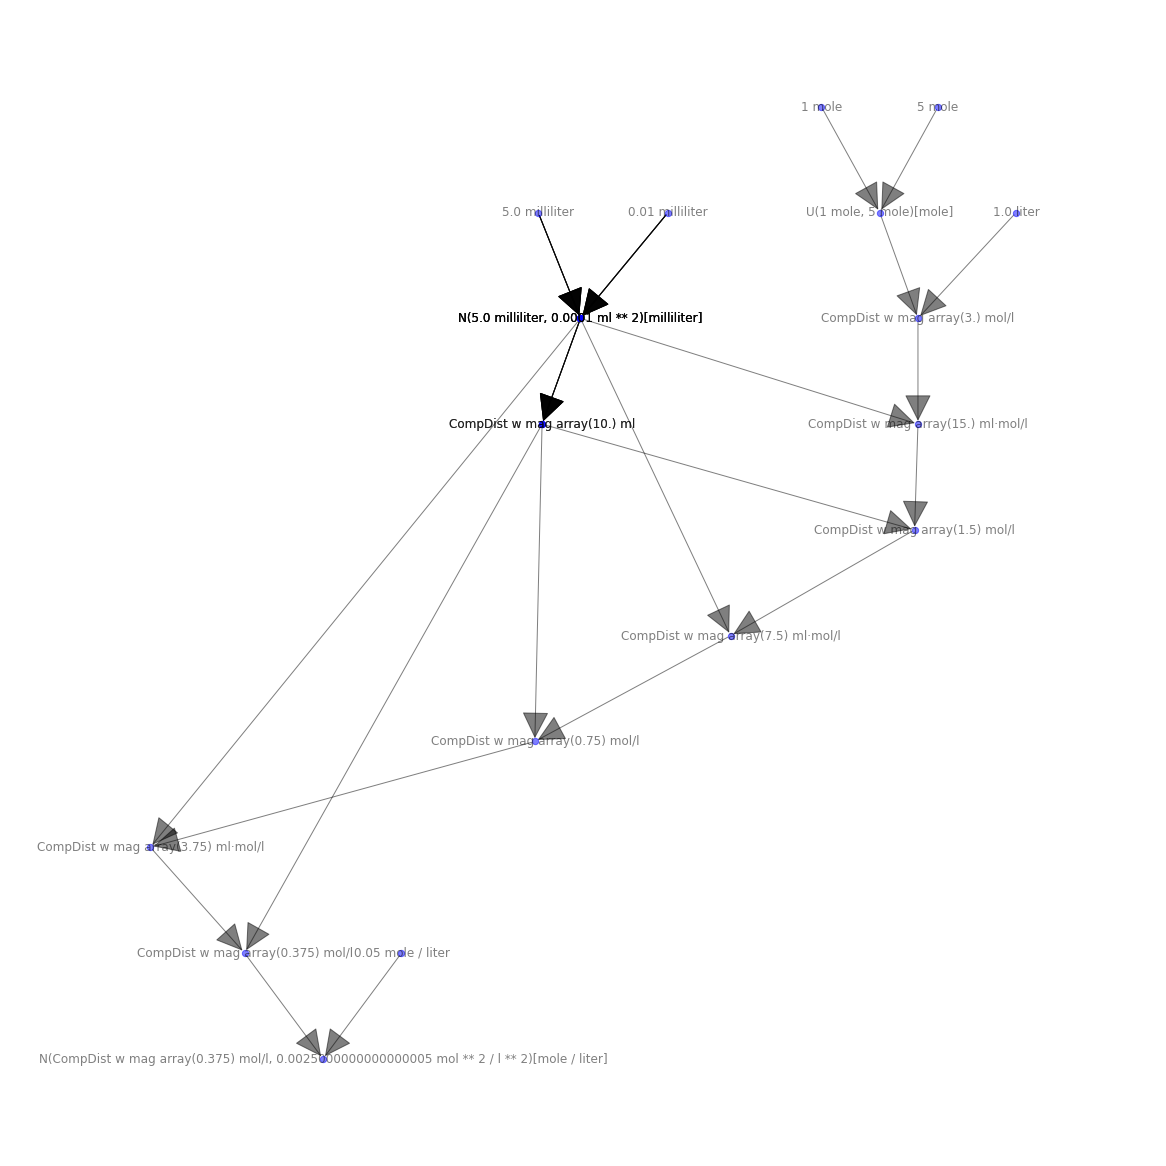

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# This example needs Graphviz and either PyGraphviz or pydot
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

G = concentration.g

labels = {}    
observed_node = concentration

pos = graphviz_layout(G, prog='dot', args='-Granksep=6 -Gnodesep=6') #nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)
#nx.draw_networkx_labels(G,pos,labels, font_color='r', font_size='30')
plt.axis("equal")
plt.show()

In [12]:
model = graphs_to_numpyro_model([concentration.g])
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 10000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs = {
    concentration: Q(0.375, ureg.mole / ureg.liter) # true concentration is 3M
})

sample: 100%|██████████| 30000/30000 [00:30<00:00, 996.28it/s, 7 steps of size 8.11e-01. acc. prob=0.86] 


In [13]:
with numpyro.handlers.seed(rng_seed=0):
    model_dict = model()
    print(model_dict)

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.114.gea315d0.dirty-py3.9.egg/bellini/api/_numpyro.py:52: UserWarning: observed node magic_measurer_Well containing CompDist w mag array(0.375) mol/l of glucose in CompDist w mag array(10.) ml of water_concentration_0 was not given data to condition on. no conditioning performed.


{<Quantity(1, 'mole')>: <Quantity(1, 'mole')>, <Quantity(5, 'mole')>: <Quantity(5, 'mole')>, U(1 mole, 5 mole)[mole]: <Quantity(1.421475887298584, 'mole')>, <Quantity(1.0, 'liter')>: <Quantity(1.0, 'liter')>, CompDist w mag array(3.) mol/l: <Quantity(1.421475887298584, 'mole / liter')>, <Quantity(5.0, 'milliliter')>: <Quantity(5.0, 'milliliter')>, <Quantity(0.01, 'milliliter')>: <Quantity(0.009999999776482582, 'milliliter')>, N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]: <Quantity(4.994133472442627, 'milliliter')>, CompDist w mag array(15.) ml·mol/l: <Quantity(7.099040508270264, 'milliliter * mole / liter')>, N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]: <Quantity(5.004864692687988, 'milliliter')>, CompDist w mag array(10.) ml: <Quantity(9.998998641967773, 'milliliter')>, CompDist w mag array(1.5) mol/l: <Quantity(0.7099751234054565, 'mole / liter')>, N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]: <Quantity(5.002171516418457, 'milliliter')>, CompDist w mag array(7.5) ml·mol/l: <Quant


                                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                                  U(1 mole, 5 mole)[mole]      3.00      0.40      3.00      2.33      3.66  26546.45      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_0      5.00      0.01      5.00      4.98      5.02  27803.10      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_1      5.00      0.01      5.00      4.98      5.02  26993.96      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_2      5.00      0.01      5.00      4.98      5.02  27085.77      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_3      5.00      0.01      5.00      4.98      5.02  25967.96      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_4      5.00      0.01      5.00      4.98      5.02  27607.85      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_5      5.00      0.01      5.00      4.98      

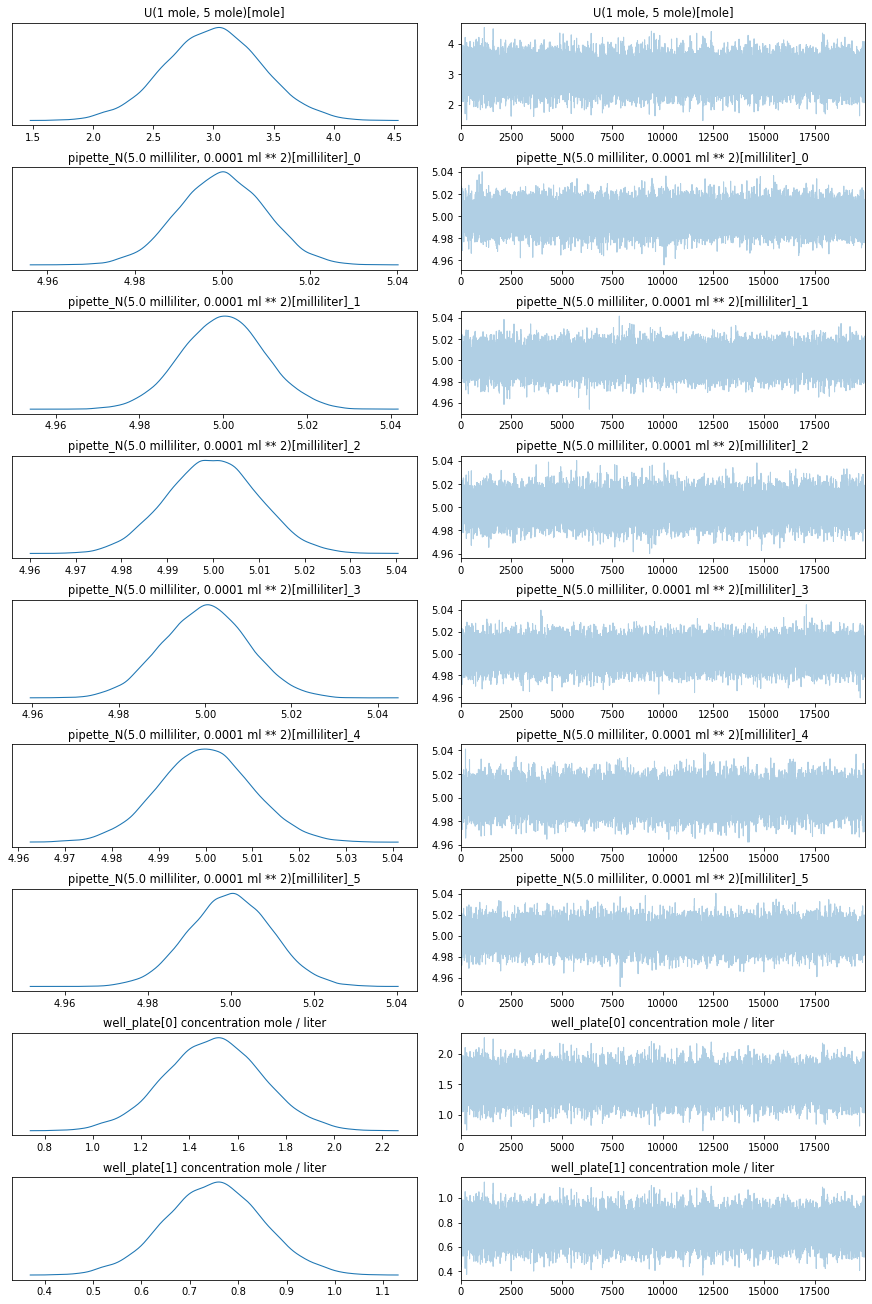

In [14]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

### B) Procedural Mode

We can also do this in a procedural style. In this mode, we produce a Procedure object, add the experimental objects and devices, and manipulate the experimental state via `Procedure`'s built-in methods.

In [15]:
# we're just gonna make the objects again to be safe
sugar_water = Solution(
    mixture = glucose * Uniform(Q(1, ureg.mole), Q(5, ureg.mole)), # set a uniform prior on concentration
    solvent = water * Q(1.0, ureg.liter)
)

sugar_water_bottle = Container(
    solution = sugar_water
)

bulk_water = Container(
    solution = water * Q(1.0, ureg.liter)
)
well_plate = [Container() for i in range(3)]
pipette = LiquidTransfer("pipette", var=Q(0.01, ureg.milliliter))

We now make a Procedure object that contains experimental objects (things that change over the course of the experiment) and experimental devices (things that manipulate or measure experimental states)

In [16]:
from bellini.procedure import Procedure

procedure = Procedure(
    objects={
        "sugar_water": sugar_water_bottle,
        "water": bulk_water,
        "well_plate": well_plate
    },
    devices={
        "pipette": pipette,
        "conc_measure": conc_measure
    }
)

In [17]:
from bellini.reference import Reference as Ref
well_plate_ref = Ref("well_plate")

We can use `perform` to call on experimental devices that can manipulate experimental states. In this case, "pipette" is our pipette we created earlier, and we use it to transfer liquid from source to sink.

In [18]:
procedure.perform("pipette", source_ref="sugar_water", sink_ref=well_plate_ref[0], volume=Q(5, ureg.milliliter))
procedure.perform("pipette", source_ref="water", sink_ref=well_plate_ref[0], volume=Q(5, ureg.milliliter))
procedure.perform("pipette", source_ref=well_plate_ref[0], sink_ref=well_plate_ref[1], volume=Q(5, ureg.milliliter))
procedure.perform("pipette", source_ref="water", sink_ref=well_plate_ref[1], volume=Q(5, ureg.milliliter))
procedure.perform("pipette", source_ref=well_plate_ref[1], sink_ref=well_plate_ref[2], volume=Q(5, ureg.milliliter))
procedure.perform("pipette", source_ref="water", sink_ref=well_plate_ref[2], volume=Q(5, ureg.milliliter))

6

`procedure` keeps track of all actions performed and generates a belief graph over all experimental objects. We can grab this and plot it using a multipartite layout to see the progression of experimental state over time (pardon the mess, I haven't gotten around to text-wrapping the labels yet).

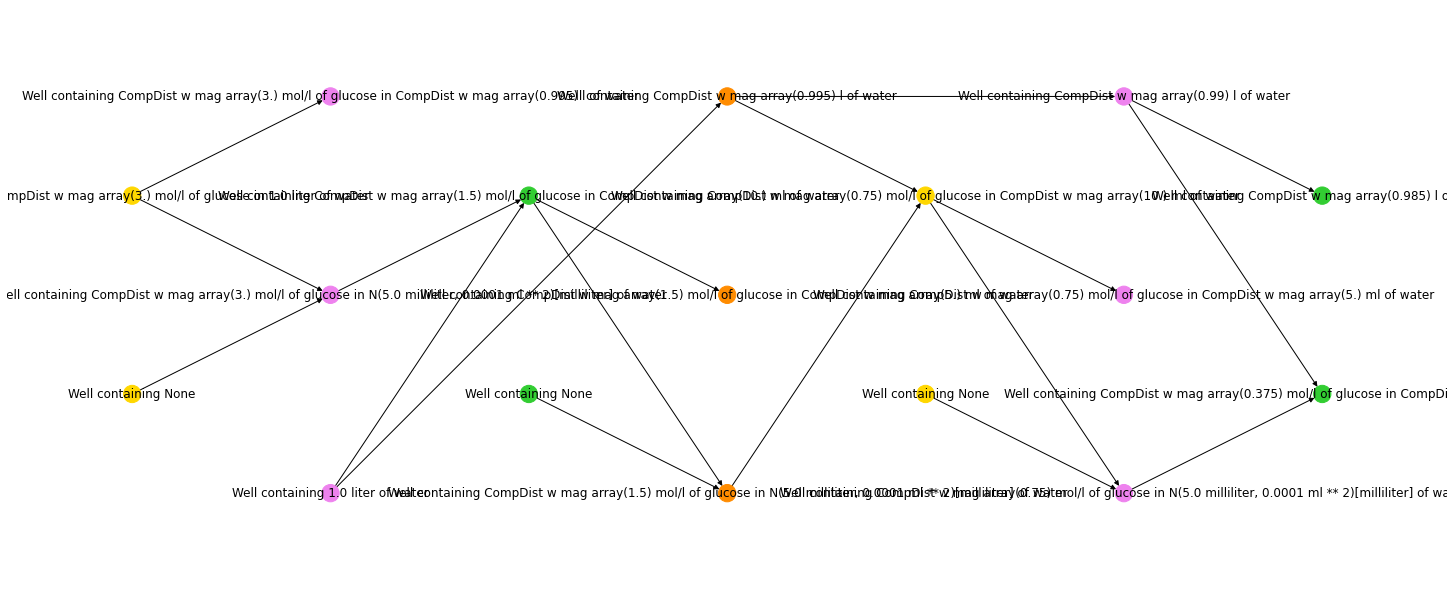

In [19]:
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
    "gold",
    "violet",
    "limegreen",
    "darkorange",
]

G = procedure.g
color = [subset_color[data['layer']] for v, data in G.nodes(data=True)]
plt.figure(figsize=(20, 8))
pos = nx.multipartite_layout(G, subset_key="layer")
nx.draw(G, pos, node_color=color, with_labels=True)
plt.axis("equal")
plt.show()

We grab measurements from devices that can measure state using the `measure` method.

In [20]:
readout = procedure.measure("conc_measure", container_ref=well_plate_ref[2], value="concentration")
readout

{'concentration': N(CompDist w mag array(0.375) mol/l, 0.0025000000000000005 mol ** 2 / l ** 2)[mole / liter]}

And similarly we can also draw a nx computation graph

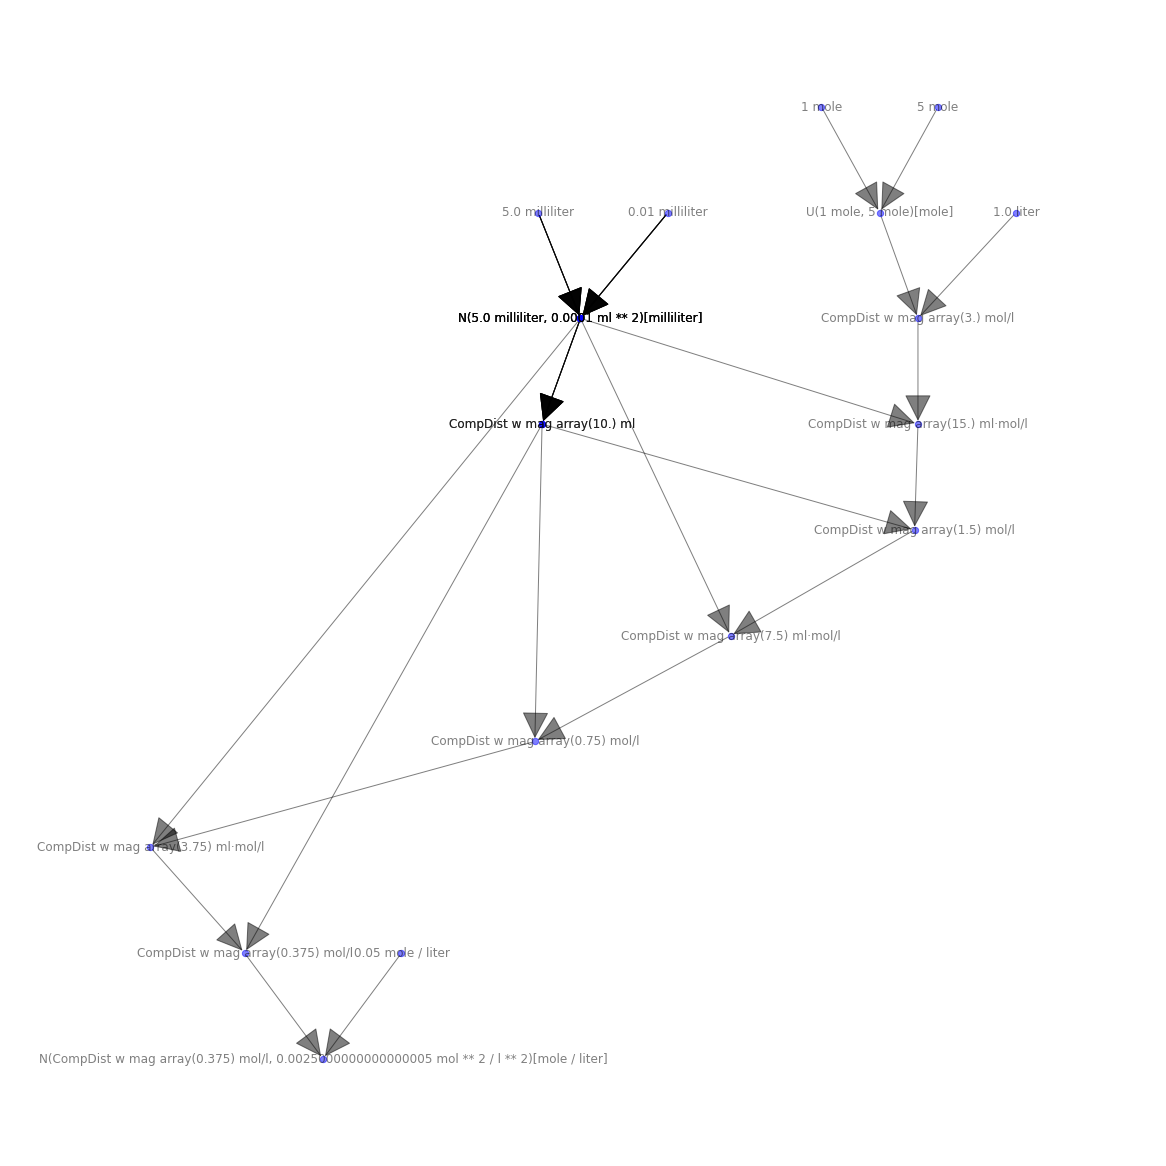

In [21]:
G = readout['concentration'].g
pos = graphviz_layout(G, prog='dot', args='-Granksep=6 -Gnodesep=6') #nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)
plt.axis("equal")
plt.show()

We can now use the graph from our readout to perform inference.

In [22]:
model = graphs_to_numpyro_model([readout['concentration'].g])
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 10000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs = {
    readout['concentration']: Q(0.25, ureg.mole / ureg.liter) # true concentration is 3M
})

sample: 100%|██████████| 30000/30000 [00:30<00:00, 977.57it/s, 7 steps of size 6.72e-01. acc. prob=0.89] 



                                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
                                  U(1 mole, 5 mole)[mole]      2.01      0.39      2.00      1.38      2.65  20699.60      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_0      5.00      0.01      5.00      4.98      5.02  33255.57      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_1      5.00      0.01      5.00      4.98      5.02  29250.09      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_2      5.00      0.01      5.00      4.98      5.02  31268.18      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_3      5.00      0.01      5.00      4.98      5.02  31066.64      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_4      5.00      0.01      5.00      4.98      5.02  33319.89      1.00
  pipette_N(5.0 milliliter, 0.0001 ml ** 2)[milliliter]_5      5.00      0.01      5.00      4.98      

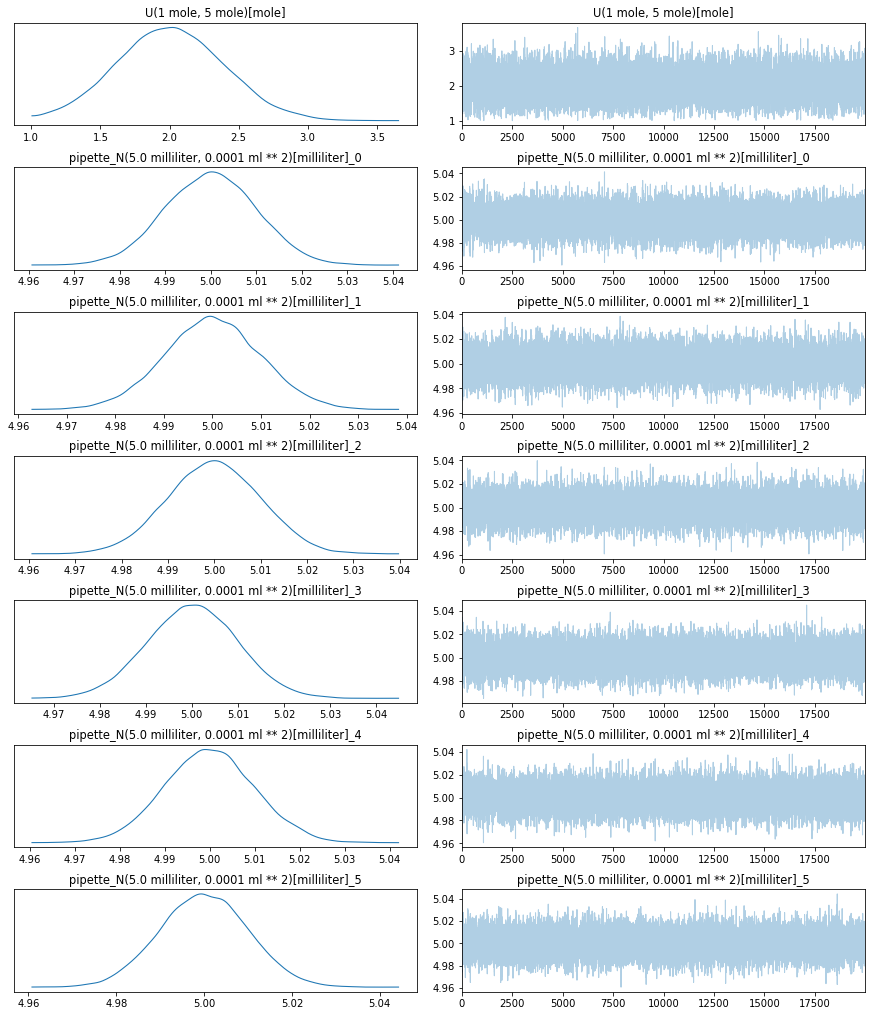

In [23]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

Again, the inference seems to work well, as our inferred initial concentration is 2M, which matches the observed value as 0.25 M * 8 = 2 M